======================================================================================================

**Disclaimer**: Parts of this notebook are adapted from this [**Open Source Project**](https://github.com/AssistiveRoboticsUNH/bc_tutorial)  with minor modifications. Credit to the original authors.

======================================================================================================

# Workshop 7
## Behavior Cloning - Part 1 (Gym Environmet)
========================================

### installation for colab
To Run in Colab: uncomment and run the following

In [ ]:
!git clone https://github.com/AssistiveRoboticsUNH/bc_tutorial.git
!pip install gym==0.26.2

In [ ]:
# Uninstall the current numpy
!pip uninstall -y numpy

# Install a compatible version of numpy
!pip install numpy==1.23.5

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pickle
import imageio

### Prepare data

In [ ]:
# data_path = "expert_data/human_demos_4_-111.0.pkl"
data_path = "/content/bc_tutorial/mountain_car/expert_data/human_demos_4_-111.0.pkl"


with open(data_path, 'rb') as f:
    trajs = pickle.load(f)

print(f"Number of trajectories: {len(trajs)}")

Number of trajectories: 4


In [ ]:
states=[]
actions=[]
for traj in trajs:
    for state,action in traj:
        states.append(state)
        actions.append(action)

states=np.array(states)
actions=np.array(actions)

states.shape,actions.shape

((438, 2), (438,))

In [ ]:
num_classes = np.max(actions)+1
num_classes

3

In [ ]:
data_loader = torch.utils.data.DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True)

batch=next(iter(data_loader))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 2]), torch.Size([64]))

### Training

In [ ]:
class BcNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(BcNet, self).__init__()
        self.layer1 = nn.Linear(state_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, action_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        # x = F.softmax(x, dim=1)
        return x

In [ ]:
bc= BcNet(2, 3)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(bc.parameters(), lr = learning_rate)

In [ ]:
loss_list = []
n_epoch = 250

for itr in range(0, n_epoch+1):
    for batch_states, batch_actions in data_loader:
        y_pred = bc(batch_states)
        loss = criterion(y_pred, batch_actions)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    if itr % 10 == 0:
        print(f'iteration: {itr}, loss: {loss.item()}')

iteration: 0, loss: 0.7733123302459717
iteration: 10, loss: 0.4502233862876892
iteration: 20, loss: 0.18849170207977295
iteration: 30, loss: 0.11881274729967117
iteration: 40, loss: 0.0870705097913742
iteration: 50, loss: 0.1232917308807373
iteration: 60, loss: 0.054407257586717606
iteration: 70, loss: 0.08386842161417007
iteration: 80, loss: 0.042612042278051376
iteration: 90, loss: 0.3174859285354614
iteration: 100, loss: 0.07285166531801224
iteration: 110, loss: 0.06183181703090668
iteration: 120, loss: 0.08942457288503647
iteration: 130, loss: 0.10972489416599274
iteration: 140, loss: 0.10326886922121048
iteration: 150, loss: 0.05471064895391464
iteration: 160, loss: 0.0600166842341423
iteration: 170, loss: 0.06091376766562462
iteration: 180, loss: 0.17406980693340302
iteration: 190, loss: 0.13942264020442963
iteration: 200, loss: 0.03585389256477356
iteration: 210, loss: 0.10615640878677368
iteration: 220, loss: 0.061684466898441315
iteration: 230, loss: 0.06145818531513214
iterat

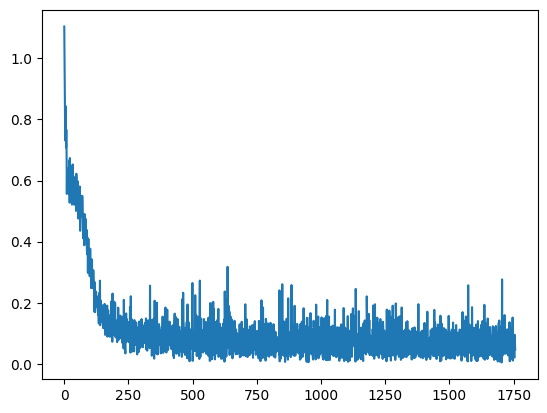

In [ ]:
plt.plot(loss_list)

In [ ]:
bc.eval()
train_x=torch.tensor(states).float()
train_y=torch.tensor(actions).long()
with torch.no_grad():
    y_pred = bc(train_x)
    correct = (torch.argmax(y_pred, dim=1) == train_y ).type(torch.FloatTensor)
    print('training accuracy: ', correct.mean())

training accuracy:  tensor(1.)


### Rollout

In [ ]:
env_name='MountainCar-v0'

In [ ]:
def play_an_episode(env_name, model, video_path=None, max_steps=1000):
    video_writer=None
    if video_path is not None:
        print(f'Saving video to {video_path}')
        video_writer = imageio.get_writer(video_path, fps=20)
        env=gym.make(env_name, render_mode='rgb_array')
    else:
        env=gym.make(env_name)

    obs,_=env.reset()
    rewards=0
    step=0
    for _ in range(max_steps):
        step+=1
        obs=torch.tensor(obs).float()
        predict=model(obs)
        action=torch.argmax(predict).item()
        obs, reward, done, trunc,_ = env.step(action)

        if video_path is not None:
            image=env.render()
            video_writer.append_data(image)

        rewards+=reward
        if done or trunc:
            break

    if video_path is not None:
        video_writer.close()
    return {'reward':rewards, 'step':step-1}

In [ ]:
scores=[]
n_trajectory=20
for i in range(n_trajectory):
    stats=play_an_episode(env_name, bc)
    rewards=stats['reward']
    print(f'episode #{i} reward: {rewards:0.2f}')
    scores.append(rewards)

print(f'\n score: {np.mean(scores):0.2f} +- {np.std(scores):0.2f}')

episode #0 reward: -200.00
episode #1 reward: -126.00
episode #2 reward: -200.00
episode #3 reward: -200.00
episode #4 reward: -113.00
episode #5 reward: -118.00
episode #6 reward: -113.00
episode #7 reward: -114.00
episode #8 reward: -121.00
episode #9 reward: -111.00
episode #10 reward: -117.00
episode #11 reward: -112.00
episode #12 reward: -115.00
episode #13 reward: -113.00
episode #14 reward: -113.00
episode #15 reward: -113.00
episode #16 reward: -113.00
episode #17 reward: -115.00
episode #18 reward: -113.00
episode #19 reward: -115.00

 score: -127.75 +- 30.54


### Let's render and save a video using the learned policy.

In [ ]:
stats=play_an_episode(env_name, bc, video_path='bc_mc.mp4')
stats

Saving video to bc_mc.mp4


{'reward': -116.0, 'step': 115}

In [ ]:
# from IPython.display import Video
# Video('bc_mc.mp4' )

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = 'bc_mc.mp4'

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")